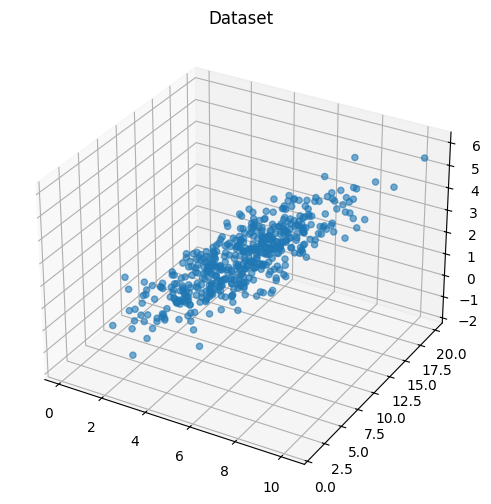

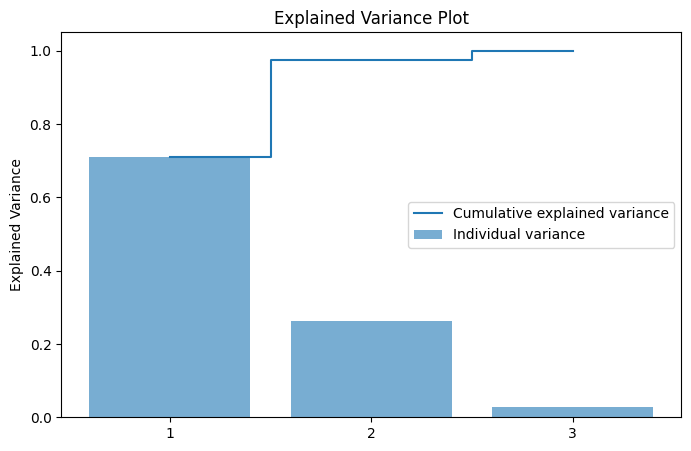

(500, 3)


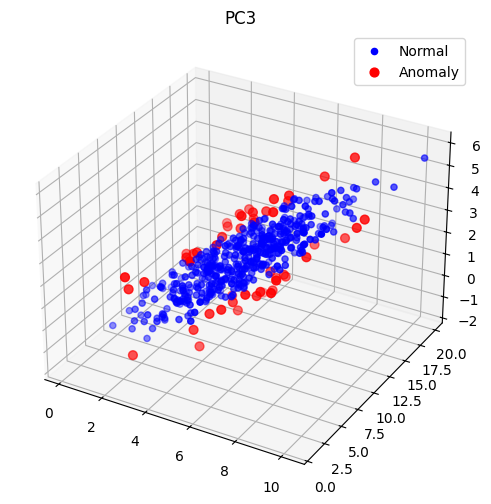

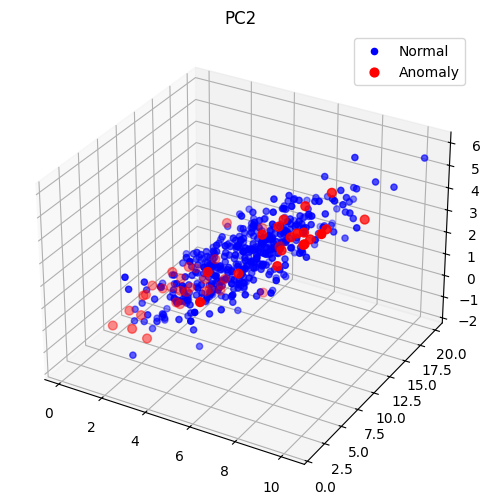

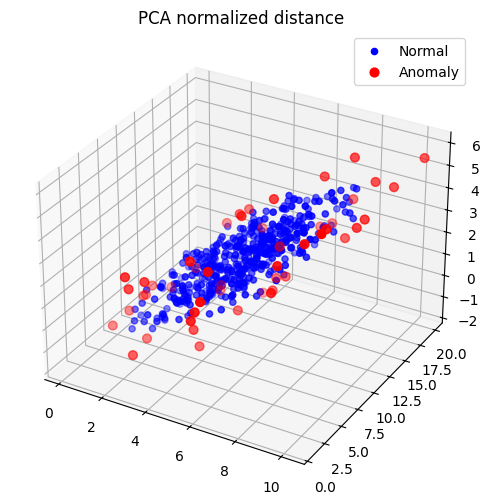

In [22]:
# Ex. 1
# 1. In the first exercise you will generate a 3D dataset with 500 points using
# np.random.multivariate normal function with the mean vector [5, 10,
# 2] and the covariance matrix [[3, 2, 2], [2, 10, 1], [2, 1, 2]] and plot it
# (3D). Then you will perform the PCA steps from the course (center data,
# compute covariance matrix, EVD).
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mean = np.array([5, 10, 2])
cov = np.array([
    [3, 2, 2],
    [2, 10, 1],
    [2, 1, 2]
])

np.random.seed(11)
X = np.random.multivariate_normal(mean, cov, size=500)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=20, alpha=0.6)
ax.set_title("Dataset")
plt.show()


# PCA 
X_centered = X - X.mean(axis=0)

Sigma = np.cov(X_centered, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(Sigma)


# 2. Plot in the same figure both the cumulative explained variance (computed with the sorted [descending] eigenvalues and the numpy.cumsum
# function) with the pyplot.step function and the individual variances (respecting the order) - using the pyplot.bar function.
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

expl_var = eigenvalues / eigenvalues.sum()
cum_expl_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

plt.figure(figsize=(8,5))
plt.step(range(1,4), cum_expl_var, where='mid', label="Cumulative explained variance")
plt.bar(range(1,4), expl_var, alpha=0.6, label="Individual variance")
plt.xticks([1,2,3])
plt.ylabel("Explained Variance")
plt.legend()
plt.title("Explained Variance Plot")
plt.show()


# 3. Project the data in the new space and identify the outliers based on the deviation of the values over the dimension corresponding to the 3rd principal
# component (compared to the mean of all the values of the same component). Use 0.1 as contamination rate and the numpy.quantile function
# in order to find the corresponding threshold and predict the labels. Plot
# the dataset again (using a different color for points labeled as anomalies).
# Repeat the same steps for the second principal component.

X_pca = X_centered @ eigenvectors
print(X_pca.shape)

# PC3
pc3 = X_pca[:, 2]
# print(pc3)
threshold_pc3 = np.quantile(np.abs(pc3 - pc3.mean()), 0.9)  # contamination 0.1
y_pred_pc3 = np.abs(pc3 - pc3.mean()) > threshold_pc3

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[~y_pred_pc3,0], X[~y_pred_pc3,1], X[~y_pred_pc3,2], color="blue", s=20, label="Normal")
ax.scatter(X[y_pred_pc3,0], X[y_pred_pc3,1], X[y_pred_pc3,2], color="red", s=40, label="Anomaly")

ax.set_title("PC3")
ax.legend()
plt.show()

# PC2
pc2 = X_pca[:, 1]
threshold_pc2 = np.quantile(np.abs(pc2 - pc2.mean()), 0.9)
y_pred_pc2 = np.abs(pc2 - pc2.mean()) > threshold_pc2

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[~y_pred_pc2,0], X[~y_pred_pc2,1], X[~y_pred_pc2,2], color="blue", s=20, label="Normal")
ax.scatter(X[y_pred_pc2,0], X[y_pred_pc2,1], X[y_pred_pc2,2], color="red", s=40, label="Anomaly")

ax.set_title("PC2")
ax.legend()
plt.show()


# 4. Project the data in the new space and identify the outliers based on the
# normalized distance (by the corresponding standard deviation) of the data
# points to the centroid (in the new space) along all the principal components
# (follow the steps from the algorithm in the first part of the lab). Plot the
# dataset again (using a different color for points labeled as anomalies)

# Normalize
X_norm = X_pca / np.sqrt(eigenvalues)

dist2 = np.sum(X_norm**2, axis=1)

threshold_dist = np.quantile(dist2, 0.9)
y_pred_dist = dist2 > threshold_dist

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[~y_pred_dist,0], X[~y_pred_dist,1], X[~y_pred_dist,2], color="blue", s=20, label="Normal")
ax.scatter(X[y_pred_dist,0], X[y_pred_dist,1], X[y_pred_dist,2], color="red", s=40, label="Anomaly")

ax.set_title("PCA normalized distance")
ax.legend()
plt.show()

X: (49097, 9)
y: (49097,)
Labels: (array([0, 1], dtype=uint8), array([45586,  3511]))
Train: (29458, 9)  Test: (19639, 9)
Train contamination: 0.07152556181682396


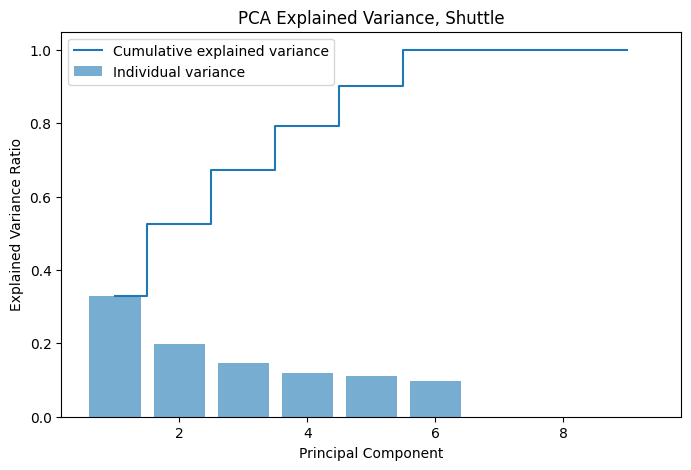

PCA BA TRAIN: 0.9752082461478256
PCA BA TEST : 0.9708779881524603
KPCA balanced accuracy - TRAIN: 0.6366
KPCA balanced accuracy - TEST : 0.7284


In [38]:
#  Ex. 2
# 1. In this exercise you will use the shuttle dataset. Split the data in a training set and a testing set (60% of data). Standardize your data and fit a
# pyod.models.pca.PCA model with the training set using the real contamination rate of the training set. Plot the cumulative explained variance
# and the individual variances as in the previous exercise (you can access
# the variances with the explained variance attribute).
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
import matplotlib.pyplot as plt
from pyod.models.pca import PCA
from sklearn.metrics import balanced_accuracy_score
from pyod.models.kpca import KPCA

data = loadmat("shuttle 1.mat")

X = data["X"]
y = data["y"].ravel()

print("X:", X.shape)
print("y:", y.shape)
print("Labels:", np.unique(y, return_counts=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)

X_train_std, X_test_std = standardizer(X_train, X_test)



contamination = np.mean(y_train == 1)
print("Train contamination:", contamination)

clf_pca = PCA(contamination=contamination, random_state=1)
clf_pca.fit(X_train_std)

expl_var = clf_pca.explained_variance_
expl_var_ratio = expl_var / expl_var.sum()
cum_expl_var = np.cumsum(expl_var_ratio)

plt.figure(figsize=(8,5))
plt.step(range(1, len(expl_var)+1), cum_expl_var, where="mid", label="Cumulative explained variance")
plt.bar(range(1, len(expl_var)+1), expl_var_ratio, alpha=0.6, label="Individual variance")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance, Shuttle")
plt.legend()
plt.show()

# 2. Compute the balanced accuracy for both the train and test sets. Then fit
# the pyod.models.kpca.KPCA model with the same training data and
# compute the scores again.``
y_train_pred_pca = clf_pca.labels_
y_test_pred_pca = clf_pca.predict(X_test_std)

bal_acc_train_pca = balanced_accuracy_score(y_train, y_train_pred_pca)
bal_acc_test_pca = balanced_accuracy_score(y_test, y_test_pred_pca)

print(f"PCA BA TRAIN: {bal_acc_train_pca}")
print(f"PCA BA TEST: {bal_acc_test_pca}")

clf_kpca = KPCA(
    contamination=contamination,
    kernel='rbf',
    gamma=None,
)

clf_kpca.fit(X_train_std)

y_train_pred_kpca = clf_kpca.labels_
y_test_pred_kpca = clf_kpca.predict(X_test_std)

bal_acc_train_kpca = balanced_accuracy_score(y_train, y_train_pred_kpca)
bal_acc_test_kpca = balanced_accuracy_score(y_test, y_test_pred_kpca)

print(f"KPCA BA TRAIN: {bal_acc_train_kpca}")
print(f"KPCA BA TEST: {bal_acc_test_kpca}")

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3237 - val_loss: 0.3123
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3089 - val_loss: 0.3049
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3010 - val_loss: 0.2967
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2923 - val_loss: 0.2873
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2822 - val_loss: 0.2764
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2705 - val_loss: 0.2640
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2575 - val_loss: 0.2505
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2435 - val_loss: 0.2348
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2261 - val_loss: 0.2168
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2086 - val_loss: 0.2002
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1933 - val_loss: 0.1863
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1

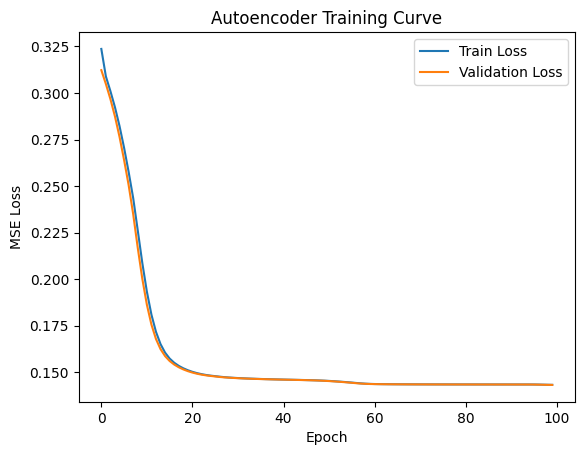

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step
Anomaly threshold = 0.14569430181679582
BA Train: 0.7379613349077658
BA Test: 0.7409920191898424


In [39]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

# Ex. 3
# For the last 2 exercises you will need to install tensorflow using pip install
# tensorflow.
# 1. In this exercise you will use the shuttle dataset from ODDS. Load the data
# using scipy.io.loadmat() and use train test split() to split it into train
# and test subsets (use 50% of data for testing). Use min-max normalization
# to bring your train data in the [0-1] range.
data = loadmat("shuttle.mat")

X = data["X"]
y = data["y"].ravel() # 1 = anom, 0 = norm

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

x_min = X_train.min(axis=0)
x_max = X_train.max(axis=0)

X_train_norm = (X_train - x_min) / (x_max - x_min + 1e-8)
X_test_norm  = (X_test  - x_min) / (x_max - x_min + 1e-8)

# 2. Design an Autoencoder class that subclasses keras.Model. Use the
# keras.Sequential model to create encoder and decoder submodels that
# contain only keras.layers.Dense layers. The 2 submodels should contain layers with [8, 5, 3] and [5, 8, 9] output units. Use relu activation
# function for each layer except the last one (from the decoder), which will
# use sigmoid activation.

class Autoencoder(Model):
    def __init__(self):
        super().__init__()

        self.encoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(5, activation='relu'),
            layers.Dense(3, activation='relu')
        ])

        self.decoder = Sequential([
            layers.Dense(5, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(9, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

ae = Autoencoder()

# 3. Compile your model using adam optimizer and mse loss and fit it with
# your training data using 100 epochs and a batch size of 1024 (use the
# test data as validation data in the trainig process). Plot the training and
# validation loss.
ae.compile(optimizer='adam', loss='mse')

history = ae.fit(
    X_train_norm, X_train_norm,
    validation_data=(X_test_norm, X_test_norm),
    epochs=100,
    batch_size=1024,
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Curve")
plt.legend()
plt.show()


# 4. In order to obtain the scores for the training data pass it through the
# autoencoder and get the reconstruction error for each sample. Compute
# a threshold that will be used to classify data with the numpy.quantile
# function and the contamination rate of the dataset. Compute the balanced
# accuracy for both the training and testing set.

# reconstructed outputs
train_recon = ae.predict(X_train_norm)
test_recon  = ae.predict(X_test_norm)

# squared reconstruction error
train_err = np.mean((train_recon - X_train_norm)**2, axis=1)
test_err  = np.mean((test_recon - X_test_norm)**2, axis=1)

contamination = np.mean(y_train == 1)

threshold = np.quantile(train_err, 1 - contamination)
print("Anomaly threshold =", threshold)

y_pred_train = (train_err > threshold).astype(int)
y_pred_test  = (test_err  > threshold).astype(int)

bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
bal_acc_test  = balanced_accuracy_score(y_test, y_pred_test)

print("BA Train:", bal_acc_train)
print("BA Test:", bal_acc_test)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0353 - val_loss: 0.0058
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0020 - val_loss: 0.0019
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
0.0029652386
C

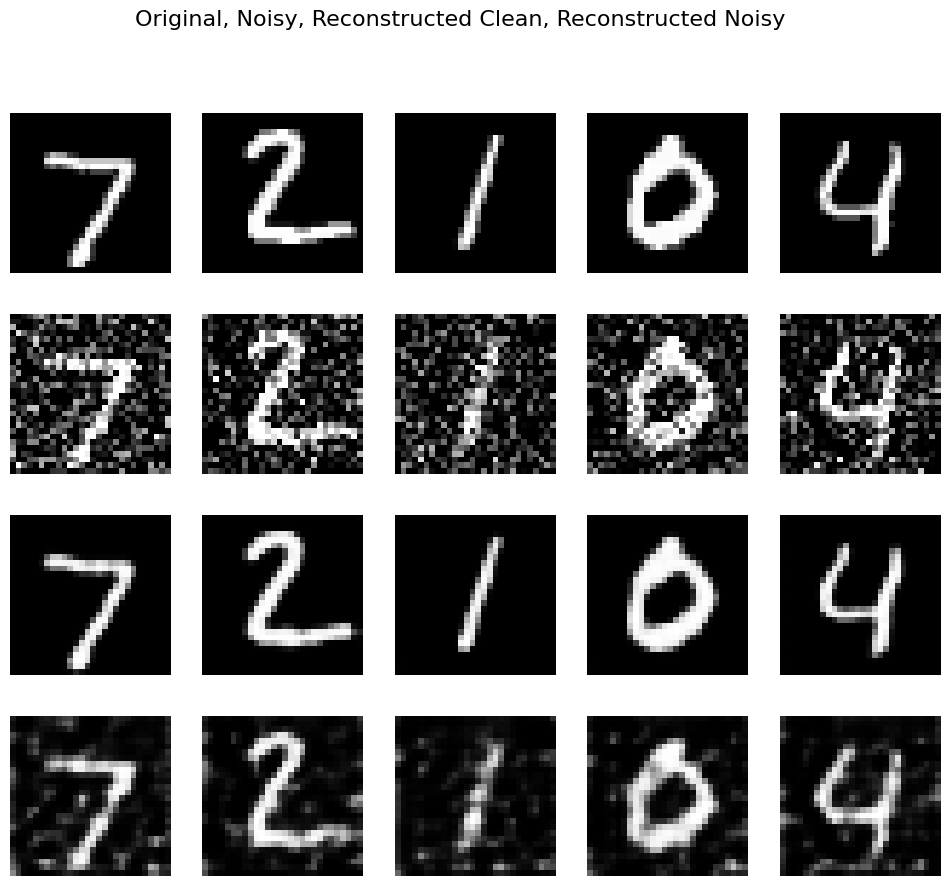

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0430 - val_loss: 0.0111
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0089 - val_loss: 0.0086
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


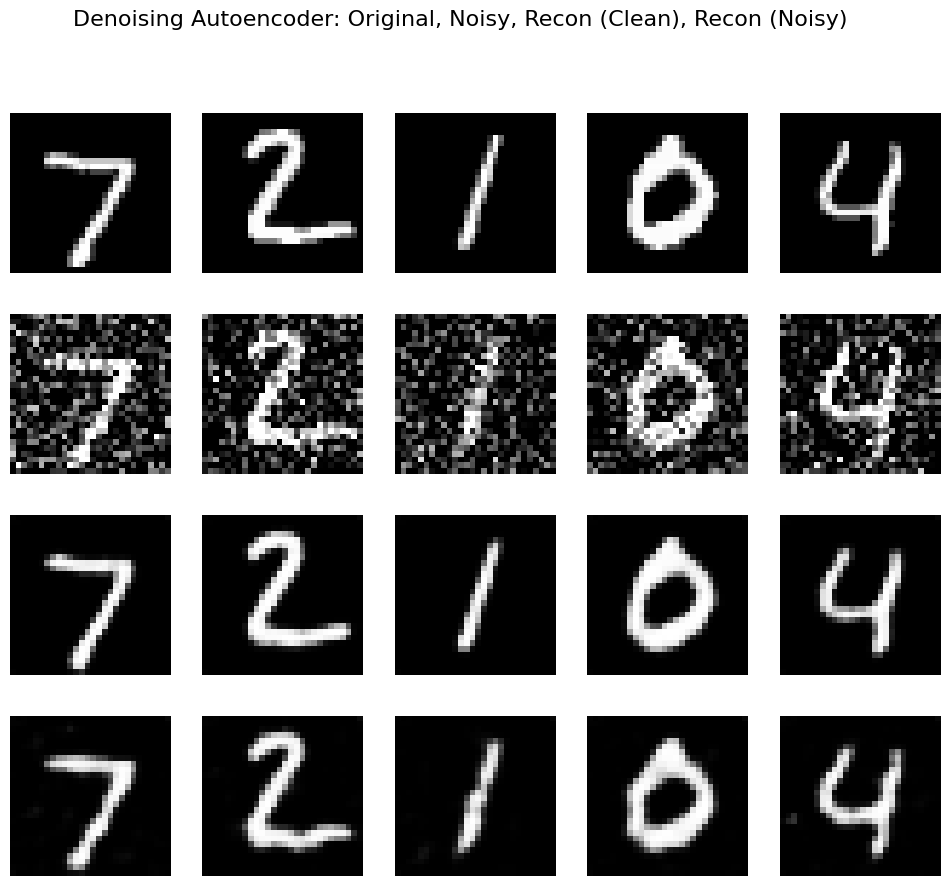

In [55]:
# Ex. 4
# 1. In this exercise we will use the mnist dataset from tensorflow.keras.datasets.mnist.
# After you load the dataset with tensorflow.keras.datasets.mnist.load data()
# you will normalize it by dividing with 255. In order to simulate anomalies,
# you will add some noise to the images with tensorflow.random.normal
# (multiplied by a factor of 0.35). You will use tensorflow.clip by value
# to keep the range of the pixels [0, 1].

data = np.load("mnist.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test  = data["x_test"]
y_test  = data["y_test"]

x_train = x_train.astype("float32") / 255.
x_test  = x_test.astype("float32")  / 255.

# (b, 28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

# Add noise
noise = tf.random.normal(shape=x_test.shape) * 0.35
x_test_noisy = x_test + noise
x_test_noisy = tf.clip_by_value(x_test_noisy, 0., 1.)


# 2. Design a Convolutional Autoencoder class that uses the keras.Sequential
# model to create encoder and decoder submodels that contain keras.layers.Conv2D
# and keras.layers.Conv2DTranspose layers. The encoder will contain:
# • 1 Conv2D layer with 8 (3 X 3) filters, relu activation, strides=2 and
# padding - ’same’
# • 1 Conv2D layer with 4 (3 X 3) filters and the rest of params as
# above
# The decoder will consist of:
# • 1 Conv2DTranspose layer with the same parameters as the last
# layer of the encoder
# • 1 Conv2DTranspose layer with the same parameters as the first
# layer of the encoder
# • 1 Conv2D layer with 1 filter with sigmoid activation that will reconstruct the original image
class ConvAutoencoder(Model):
    def __init__(self):
        super().__init__()

        self.encoder = Sequential([
            layers.Conv2D(8, (3,3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(4, (3,3), activation='relu', strides=2, padding='same')
        ])

        self.decoder = Sequential([
            layers.Conv2DTranspose(4, (3,3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(8, (3,3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoenc = ConvAutoencoder()


# 3. Compile your model using adam optimizer and mse loss and fit it with
# your training data using 10 epochs and a batch size of 64 (use the test
# data as validation data in the trainig process). Use only the original
# train data for training. Compute the reconstruction loss for the training
# data and a threshold (that will be the mean of the reconstruction errors
# + their standard deviation). Based on the threshold and the obtained
# reconstruction errors classify both the original test images and the ones
# that have the added noise (and compute the corresponding accuracy).
autoenc.compile(optimizer='adam', loss='mse')

history = autoenc.fit(
    x_train, x_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, x_test),
    verbose=1
)


# 4. Plot in the same figure, on four rows, 5 test images: on the first row -
# the original ones, on the second one - the images with the added noise, on
# the third, the reconstructed images obtained from the original ones and
# on the last row the reconstructed images obtained from the images with
# added noise.

recon_clean = autoenc.predict(x_test)
recon_noisy = autoenc.predict(x_test_noisy)

# MSE per sample
err_clean = np.mean((recon_clean - x_test)**2, axis=(1,2,3))
err_noisy = np.mean((recon_noisy - x_test_noisy)**2, axis=(1,2,3))

recon_train = autoenc.predict(x_train)
err_train = np.mean((recon_train - x_train)**2, axis=(1,2,3))

threshold = err_train.mean() + err_train.std()
print(threshold)

y_true = np.concatenate([
    np.zeros_like(err_clean),
    np.ones_like(err_noisy)
])

y_pred = np.concatenate([
    (err_clean > threshold).astype(int),
    (err_noisy > threshold).astype(int)
])

accuracy = np.mean(y_true == y_pred)
print("Classification accuracy:", accuracy)


n = 5
plt.figure(figsize=(12,10))

for i in range(n):
    # original clean image
    plt.subplot(4, n, i+1)
    plt.imshow(np.array(x_test[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # noisy image
    plt.subplot(4, n, n + i + 1)
    plt.imshow(np.array(x_test_noisy[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # reconstruction of clean
    plt.subplot(4, n, 2*n + i + 1)
    plt.imshow(np.array(recon_clean[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # reconstruction of noisy
    plt.subplot(4, n, 3*n + i + 1)
    plt.imshow(np.array(recon_noisy[i]).squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Original, Noisy, Reconstructed Clean, Reconstructed Noisy", fontsize=16)
plt.show()

# 5. Modify the training stage in order to obtain a Denoising Autoencoder and
# print the same figure again.

noise_train = tf.random.normal(shape=x_train.shape) * 0.35
x_train_noisy = x_train + noise_train
x_train_noisy = tf.clip_by_value(x_train_noisy, 0., 1.)

denoising_ae = ConvAutoencoder()
denoising_ae.compile(optimizer='adam', loss='mse')

# 3. Train: noisy -> clean
history_denoise = denoising_ae.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_noisy, x_test),
    verbose=1
)

recon_clean_d = denoising_ae.predict(x_test)
recon_noisy_d = denoising_ae.predict(x_test_noisy)

n = 5
plt.figure(figsize=(12, 10))

for i in range(n):
    # Row 1 — original clean images
    plt.subplot(4, n, i + 1)
    plt.imshow(np.array(x_test[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # Row 2 — noisy images
    plt.subplot(4, n, n + i + 1)
    plt.imshow(np.array(x_test_noisy[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # Row 3 — reconstructions from clean images (denoising AE)
    plt.subplot(4, n, 2 * n + i + 1)
    plt.imshow(np.array(recon_clean_d[i]).squeeze(), cmap='gray')
    plt.axis('off')

    # Row 4 — reconstructions from noisy images (denoising AE)
    plt.subplot(4, n, 3 * n + i + 1)
    plt.imshow(np.array(recon_noisy_d[i]).squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Denoising Autoencoder: Original, Noisy, Recon (Clean), Recon (Noisy)", fontsize=16)
plt.show()